# TF Model training script: Using TFRecords created using Spark

## Imports and other initializations

In [148]:
# fairing:include-cell
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import sys
import os
from pathlib import Path
import pandas as pd
from kubeflow import fairing 
import time
import json
import logging
import imp
import yaml
import seaborn as sns
import shutil
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import normalize
from google.cloud import storage
from tensorflow.io import FixedLenFeature

from matplotlib import pyplot as plt

sys.path.append('../utilities/')
import modeldb_tf_utilities
import evaluation_utilities
import model_utilities
import tf_records_utils
imp.reload(modeldb_tf_utilities)
imp.reload(evaluation_utilities)
imp.reload(model_utilities)
imp.reload(tf_records_utils)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [149]:
# fairing:include-cell
# Global configs that would be used at all the steps of the notebook.
GCP_PROJECT = fairing.backends.gcp.guess_project_name()
NAMESPACE = fairing.backends.utils.get_current_k8s_namespace()
PROJECT_ID = GCP_PROJECT
MODELDB_CLIENT_URL = "https://modeldb.mlp.ml.gce.z8s.io/"
print(NAMESPACE)
print(GCP_PROJECT)

rmenon
zulilymodeltraining


## Configuration Parameters

### Model and Data Related

In [150]:
# fairing:include-cell
# YAML file containing model data configuration: i.e. Feature names, identification of categorical names etc
model_data_config_file_name = "./../model_configs/text_based_tfrecord_config.yaml"

# Dataset paths
data_config = {
    "training":'gs://zulilymodeltraining/rmenon/data/tfrecords/version_8/train/',
    "validation":'gs://zulilymodeltraining/rmenon/data/tfrecords/version_8/valid/',
    "test":'gs://zulilymodeltraining/rmenon/data/tfrecords/version_8/test/',
}

# Path to save trained model and other model-related specs
model_data_path_prefix= f"gs://personalization-tensorflow/models/text_features/"

# Model training parameters
model_fit_config = {
    "batch_size": 2048,
    "initial_lr": 1e-3,
    "epochs": 6,
    "shuffle_buffer_size": 16384,
}

# Evaluating LTR performance metrics
max_rank = 15

# Use distributed training across GPUs (only set to True if using >1GPU). Also only efficient for large models.
use_distributed_training = False

# Use checkpointed model (usually based on lowest validation loss) to generate validation metrics
use_checkpointed_model = True

# Run locally for testing
run_local = False

# Cache data from first iteration for later iterations
cache_data = False

### Feature Normalizer Related

In [151]:
# fairing:include-cell
# Parameters related to feature normalizer for the model
num_samples_to_train_normalizer = 500 # Set a sample size (in terms of number of batches). If set to None, the entire "training" set will be used to train the normalizer.
if run_local:
    num_samples_to_train_normalizer = 1

### Model DB Related

In [152]:
# fairing:include-cell
# Model DB configuration parameters
modeldb_config = {
    ## Required configs
    # These are required configs for a modeldb run. 
    # Please refer to notes here: https://confluence.zulily.com/display/tech/Notes+about+using+ModelDB if you are updaing the default
    # project and experiment name.
    "client_url": MODELDB_CLIENT_URL,
    "project_name": 'P13N_Event_Sort_Models_2021',
    "experiment_name": f"TFRecords",
    # Username is mapped into as a ModelDB tag which will help to identiy a run by an user.
    "username": NAMESPACE,
    
    ## Optional configs
    # If an experiment run name is not specified, then ModelDB will randomly assign a run_name.
    "experiment_run_name": 'v8_bn',#'4layer_1024_target_0_458_dataset_v4',
    # This parameter is by default true and is required if you are going to run multiple runs with same experiment_run_name.
    # This will prevent you from overwritng an experiment_run data and create a new run everytime a pipeline runs.
    "add_random_hash_to_run_name": 'true'
}

### Model Internal initializations based on YAML configuration

In [153]:
# fairing:include-cell
# Retrieve model configuration from YAML file.
with open(model_data_config_file_name) as file:
    model_data_config = yaml.load(file, Loader=yaml.SafeLoader)
# Do some name mappings to make code cleaner
feature_names = model_data_config['feature_names']
categorical_columns = model_data_config['categorical_columns']
categorical_columns_vocabulary_list = model_data_config['categorical_columns_vocabulary_list']
numeric_columns_to_norm = model_data_config['numeric_columns_to_norm']
vector_features = model_data_config['vector_columns']
identifier_columns = model_data_config['identifier_columns']
numeric_columns_remaining = [xx for xx in feature_names if ((xx not in categorical_columns) \
                                                            and (xx not in numeric_columns_to_norm)\
                                                            and (xx not in vector_features))]
vector_column_lengths = model_data_config['vector_column_lengths']
target_name = model_data_config['target_name']
numeric_columns_remaining.remove(target_name)

In [154]:
# fairing:include-cell
# Build TF Structure
tf_feature_descriptions = dict()
# Assume that identifier columns are first
for column in identifier_columns:
    tf_feature_descriptions[column] = tf.io.FixedLenFeature([], tf.string)
for column in feature_names:
    if column == target_name:
        tf_feature_descriptions[column] = tf.io.FixedLenFeature([], tf.int64)
    else:
        if column in categorical_columns:
            if column in vector_features:
                tf_feature_descriptions[column] = tf.io.FixedLenFeature([vector_column_lengths[column]], tf.string)
            else:
                tf_feature_descriptions[column] = tf.io.FixedLenFeature([], tf.string)  
        else:
            if column in vector_features:
                tf_feature_descriptions[column] = tf.io.FixedLenFeature([vector_column_lengths[column]], tf.float32)
            else:
                tf_feature_descriptions[column] = tf.io.FixedLenFeature([], tf.float32)

In [155]:
tf_feature_descriptions

{'send_date': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'customer_id': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'event_id': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'text_embd_style_views': FixedLenFeature(shape=[100], dtype=tf.float32, default_value=None),
 'text_embd_cart_adds': FixedLenFeature(shape=[100], dtype=tf.float32, default_value=None),
 'cust_price_median_ppt': FixedLenFeature(shape=[20], dtype=tf.float32, default_value=None),
 'cust_price_iqr_ppt': FixedLenFeature(shape=[20], dtype=tf.float32, default_value=None),
 'cust_msrp_median_ppt': FixedLenFeature(shape=[20], dtype=tf.float32, default_value=None),
 'cust_msrp_iqr_ppt': FixedLenFeature(shape=[20], dtype=tf.float32, default_value=None),
 'customer_age': FixedLenFeature(shape=[8], dtype=tf.float32, default_value=None),
 'customer_gender': FixedLenFeature(shape=[4], dtype=tf.flo

## Create/ Load a Feature Normalizer

In [156]:
# fairing:include-cell
def parse_tf_records_norm(example_proto):
    return tf.io.parse_single_example(example_proto, normalizer_tf_feature_descriptions)

def mod_features_in_data(data):
    """
    Function to modify some features
    """
    data['cust_price_median_ppt'] = tf.math.log1p(data['cust_price_median_ppt']*10000)
    data['cust_price_iqr_ppt'] = tf.math.log1p(data['cust_price_iqr_ppt']*10000)
    data['cust_msrp_median_ppt'] = tf.math.log1p(data['cust_msrp_median_ppt']*10000)
    data['cust_msrp_iqr_ppt'] = tf.math.log1p(data['cust_msrp_iqr_ppt']*10000)
    data['price_median'] = tf.math.log1p(data['price_median']*10000)
    data['price_iqr'] = tf.math.log1p(data['price_iqr']*10000)
    data['msrp_median'] = tf.math.log1p(data['msrp_median']*10000)
    data['msrp_iqr'] = tf.math.log1p(data['msrp_iqr']*10000)
    return data

In [157]:
# fairing:include-cell
# If there are feature columns to be normed, use a normalizer
if len(numeric_columns_to_norm)>0:
    st = time.time()

    normalizer_tf_feature_descriptions = {}
    for column in numeric_columns_to_norm:   
        if column in vector_features:
            normalizer_tf_feature_descriptions[column] = tf.io.FixedLenFeature([vector_column_lengths[column]], tf.float32)
        else:
            normalizer_tf_feature_descriptions[column] = tf.io.FixedLenFeature([1], tf.float32)

    # reate a data generator to run thru the training data for normalizing features
    data_batches_for_norm = tf_records_utils.get_tf_record_ds(data_config['training'])\
                            .map(parse_tf_records_norm, num_parallel_calls=AUTOTUNE) \
                            .map(mod_features_in_data, num_parallel_calls=AUTOTUNE) \
                            .batch(2048)

    #.map(mod_features_in_data, num_parallel_calls=AUTOTUNE) \

    # Pick a random sample if specified
    if num_samples_to_train_normalizer is not None:
        data_batches_for_norm = data_batches_for_norm.take(int(num_samples_to_train_normalizer))

    # Stack features: Change from dictionary format to a a stacked tensor array
    def stack_features(features):
        tf_features = None
        for key in numeric_columns_to_norm:
            if tf_features is None:
                tf_features = features[key]
            else:
                tf_features= tf.concat([tf_features, features[key]], axis=1) 
        return tf_features
    data_batches_for_norm_stacked = data_batches_for_norm.map(stack_features)


    # Train the normalizer 
    if use_distributed_training:
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            feature_normalizer = preprocessing.Normalization()
            feature_normalizer.adapt(data_batches_for_norm_stacked)
    else:
        feature_normalizer = preprocessing.Normalization()
        feature_normalizer.adapt(data_batches_for_norm_stacked)
    print('Normalizer training took {}secs'.format(time.time() - st))
else:
    feature_normalizer = None

Normalizer training took 1.7123806476593018secs


In [158]:
feature_normalizer.mean

<tf.Variable 'mean:0' shape=(85,) dtype=float32, numpy=
array([ 0.16773538,  0.45366895,  0.        ,  0.40166163,  0.5259734 ,
        0.4218287 ,  1.8216207 ,  1.7502218 ,  0.8487788 ,  1.0650543 ,
        0.9907469 ,  0.8556642 ,  0.8839725 ,  0.91379386,  1.1559806 ,
        0.8324773 ,  0.76217437,  1.4257019 ,  0.08649938,  1.5051173 ,
        0.0551321 ,  0.18875094,  0.        ,  0.17941704,  0.21988744,
        0.12666436,  1.0836467 ,  1.0255623 ,  0.34590095,  0.6048437 ,
        0.52857405,  0.42234534,  0.4597056 ,  0.45020717,  0.5441782 ,
        0.3204374 ,  0.3702801 ,  0.88747287,  0.01805433,  0.98306274,
        0.17154644,  0.47569734,  0.        ,  0.4399019 ,  0.56060266,
        0.4009023 ,  1.9202104 ,  1.808947  ,  0.9908107 ,  1.255744  ,
        1.1408458 ,  0.9629917 ,  0.9995613 ,  1.1084089 ,  1.2284244 ,
        0.85519004,  0.8513889 ,  1.6520959 ,  0.08080957,  1.5096197 ,
        0.06861306,  0.20694692,  0.        ,  0.21522272,  0.27821013,
        

In [159]:
feature_normalizer.variance

<tf.Variable 'variance:0' shape=(85,) dtype=float32, numpy=
array([0.41833094, 1.0230521 , 0.        , 0.75456905, 1.0362707 ,
       0.9794381 , 1.9245857 , 1.9444389 , 1.6108763 , 1.7141784 ,
       1.6905457 , 1.578945  , 1.6171503 , 1.7978169 , 2.3286605 ,
       1.9334575 , 1.6732022 , 2.167526  , 0.23868822, 1.7479928 ,
       0.11584257, 0.4237555 , 0.        , 0.28198662, 0.36785138,
       0.24905592, 1.2441314 , 1.183287  , 0.60439533, 0.94600874,
       0.92046756, 0.76366717, 0.8210585 , 0.9523558 , 1.2216743 ,
       0.77443683, 0.8266123 , 1.5736455 , 0.03220537, 1.3446132 ,
       0.49851814, 1.2362216 , 0.        , 0.93527293, 1.2791642 ,
       1.2527673 , 3.404235  , 3.3733861 , 2.4206693 , 2.6505628 ,
       2.5052743 , 2.1886518 , 2.3442404 , 3.1572814 , 3.4531696 ,
       2.5868046 , 2.2490947 , 3.159697  , 0.28915927, 2.4911494 ,
       0.19598015, 0.5649232 , 0.        , 0.41344276, 0.6011871 ,
       0.6984566 , 3.20174   , 3.1081784 , 1.0377214 , 1.8961473 ,
  

In [160]:
#normalizer_tf_feature_descriptions

## Model Helper functions

In [161]:
# fairing:include-cell
# Model-DB logging functions
def log_model_attributes(modeldb_expt_run):
    """
    Capturing Model attributes before starting training in ModelDB.
    """
    modeldb_expt_run.log_hyperparameters(model_fit_config)
    modeldb_expt_run.log_attributes(data_config)
    modeldb_expt_run.log_attributes(model_data_config)

    
def log_model_metrics(modeldb_expt_run, model, model_save_path, model_checkpoint_path, test_ds = None):
    """
    Capturing Model metrics at the end of training in ModelDB.
    """
    
    # Log the paths where the model and related data were saved
    modeldb_expt_run.log_artifact_path('other_model_related_data_path', model_data_path_prefix)
    modeldb_expt_run.log_artifact_path('model_save_path', model_save_path)
    modeldb_expt_run.log_artifact_path('model_checkpoint_path', model_checkpoint_path)
    
    # Log accuracy of the supplied data set (if supplied)
    if test_ds is not None:
        loss, accuracy, precision, recall = model.evaluate(test_ds)        
        modeldb_expt_run.log_metric('loss_', loss)
        modeldb_expt_run.log_metric('accuracy', accuracy)
        modeldb_expt_run.log_metric('precision', precision)
        modeldb_expt_run.log_metric('recall', recall)
        

def log_model_summary(modeldb_expt_run, model):
    """
    Log the structure of the Model
    """
    stringlist = []
    # Only store the last sequential layer
    model.get_layer(index=-1).summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)    
    
    if os.path.exists('/tmp/model/'):        
        shutil.rmtree('/tmp/model')
    os.mkdir('/tmp/model')

    with open('/tmp/model/model.txt', 'w') as f:
        f.write(short_model_summary)
    f.close()
    modeldb_expt_run.log_artifact('Model_Summary', '/tmp/model/model.txt')    
    
def parse_tf_records(example_proto):
    return tf.io.parse_single_example(example_proto, tf_feature_descriptions)

In [162]:
# fairing:include-cell
# Target variable mapping function
def parse_label_from_data(data):
    """
    Function to map the data parsed in order to generate the labels
    """
    labels = data.pop(target_name)
    
    label_0_values = tf.constant([0], dtype=tf.dtypes.int64)    
    labels = tf.reshape(labels, [-1, 1])
    labels_converted = tf.where(tf.reduce_any(tf.equal(labels, label_0_values), axis=1), 
                              tf.constant(0, dtype=tf.dtypes.int64), 
                              tf.constant(1, dtype=tf.dtypes.int64)) 
    
#     data['cust_price_median_ppt'] = tf.math.log1p(data['cust_price_median_ppt']*10000)/10
#     data['cust_price_iqr_ppt'] = tf.math.log1p(data['cust_price_iqr_ppt']*10000)/10
#     data['cust_msrp_median_ppt'] = tf.math.log1p(data['cust_msrp_median_ppt']*10000)/10
#     data['cust_msrp_iqr_ppt'] = tf.math.log1p(data['cust_msrp_iqr_ppt']*10000)/10
#     data['price_median'] = tf.math.log1p(data['price_median']*10000)/10
#     data['price_iqr'] = tf.math.log1p(data['price_iqr']*10000)/10
#     data['msrp_median'] = tf.math.log1p(data['msrp_median']*10000)/10
#     data['msrp_iqr'] = tf.math.log1p(data['msrp_iqr']*10000)/10
    data['cust_price_median_ppt'] = tf.math.log1p(data['cust_price_median_ppt']*10000)
    data['cust_price_iqr_ppt'] = tf.math.log1p(data['cust_price_iqr_ppt']*10000)
    data['cust_msrp_median_ppt'] = tf.math.log1p(data['cust_msrp_median_ppt']*10000)
    data['cust_msrp_iqr_ppt'] = tf.math.log1p(data['cust_msrp_iqr_ppt']*10000)
    data['price_median'] = tf.math.log1p(data['price_median']*10000)
    data['price_iqr'] = tf.math.log1p(data['price_iqr']*10000)
    data['msrp_median'] = tf.math.log1p(data['msrp_median']*10000)
    data['msrp_iqr'] = tf.math.log1p(data['msrp_iqr']*10000)
    #data['estimated_demand'] = data['estimated_demand']/16
    return data, labels_converted

## Model Setup and training

In [163]:
# fairing:include-cell
# Get training, test and validation data generators
training_data = tf_records_utils.get_tf_record_ds(data_config['training'])\
                .map(parse_tf_records, num_parallel_calls=AUTOTUNE) \
                .map(parse_label_from_data, num_parallel_calls=AUTOTUNE) \
                .shuffle(model_fit_config['shuffle_buffer_size']).batch(model_fit_config['batch_size'])
training_data = training_data.prefetch(buffer_size=AUTOTUNE)

validation_data = tf_records_utils.get_tf_record_ds(data_config['validation']) \
                .map(parse_tf_records, num_parallel_calls=AUTOTUNE) \
                .map(parse_label_from_data, num_parallel_calls=AUTOTUNE) \
                .batch(model_fit_config['batch_size'])
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

test_data = tf_records_utils.get_tf_record_ds(data_config['test']) \
            .map(parse_tf_records, num_parallel_calls=AUTOTUNE) \
            .map(parse_label_from_data, num_parallel_calls=AUTOTUNE) \
            .batch(model_fit_config['batch_size'])
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

if run_local:
    # For testing purposes: Selects just 1 batch of data for training, validation and test
    training_data = training_data.take(10)
    validation_data = validation_data.take(10)
    test_data = test_data.take(10)
else:
    if cache_data: # Can only use a subset of data, if caching
        # Using just 1/10th dataset for training and validation
        training_data = training_data.shard(10, 1) 
        validation_data = validation_data.shard(2, 1)

In [164]:
# training_data1 = tf_records_utils.get_tf_record_ds(data_config['training'])\
#                 .map(parse_tf_records, num_parallel_calls=AUTOTUNE)
# for row in training_data1.take(1):
#     for key, items in aa.items():
#         print(key, items)

In [165]:
# fairing:include-cell
initial_lr = model_fit_config['initial_lr']
num_epochs = model_fit_config['epochs']

# Create Model-DB Instance
modeldb_expt_run = modeldb_tf_utilities.create_modeldb_experiment_run(modeldb_config)

# Get callbacks and save paths
model_data_path_prefix = os.path.join(model_data_path_prefix, modeldb_expt_run.name)
callbacks = modeldb_tf_utilities.get_tf_callbacks(modeldb_expt_run, model_data_path_prefix)

# Save some attributes before training starts
log_model_attributes(modeldb_expt_run)

# Define model 
#loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)
loss=tf.keras.losses.MeanSquaredError()
optimizer=tf.optimizers.Adam(learning_rate=initial_lr)

# Create a distribution strategy to run on multiple GPUs
if use_distributed_training:
    with mirrored_strategy.scope():
        sort_model = model_utilities.get_tfrecord_sort_model_vector_norm(feature_normalizer, 
                                                       numeric_columns_to_norm, 
                                                       numeric_columns_remaining, 
                                                       categorical_columns,
                                                       categorical_columns_vocabulary_list,
                                                       vector_features,
                                                        vector_column_lengths)
        sort_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
else:
    sort_model = model_utilities.get_tfrecord_sort_model_vector_norm(feature_normalizer,
                                                   numeric_columns_to_norm, 
                                                   numeric_columns_remaining, 
                                                   categorical_columns,
                                                   categorical_columns_vocabulary_list,
                                                    vector_features,
                                                    vector_column_lengths)
    sort_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

log_model_summary(modeldb_expt_run, sort_model)

connection successfully established
got existing Project: P13N_Event_Sort_Models_2021
got existing Experiment: TFRecords
created new ExperimentRun: v8_2048_5layer_allnorm_cozjpi48
upload complete (Model_Summary)


In [166]:
sort_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cust_price_median_ppt (InputLay [(None, 20)]         0                                            
__________________________________________________________________________________________________
cust_price_iqr_ppt (InputLayer) [(None, 20)]         0                                            
__________________________________________________________________________________________________
cust_msrp_median_ppt (InputLaye [(None, 20)]         0                                            
__________________________________________________________________________________________________
cust_msrp_iqr_ppt (InputLayer)  [(None, 20)]         0                                            
____________________________________________________________________________________________

In [167]:
# fairing:include-cell
# Start the training process
try:
    start_time = time.time()  
    if cache_data:
        training_data = training_data.cache()
        validation_data = validation_data.cache()
    # Fit the model
    model_history = sort_model.fit(training_data, validation_data=validation_data, epochs=num_epochs, callbacks=callbacks)
    # Log time taken to fit model
    modeldb_expt_run.log_metric('model_fit_run_duration_in_secs', (time.time() - start_time))            
    # Save Model
    model_save_path = os.path.join(model_data_path_prefix, 'saved_model/')
    sort_model.save(model_save_path)
    # But reload model from checkpoint (lowest validation loss) to generate validation performance
    model_checkpoint_path = os.path.join(model_data_path_prefix, 'checkpoints/')
    if use_checkpointed_model:
        # But reload model from checkpoint (lowest validation loss) to generate validation performance        
        sort_model.load_weights(model_checkpoint_path)    
    # Log other metrics from model including validation data performance
    log_model_metrics(modeldb_expt_run, sort_model, model_save_path, model_checkpoint_path, validation_data)
    modeldb_expt_run.log_tag('success')
except:
    modeldb_expt_run.log_tag('failed_run')
    raise

Epoch 1/6


/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['customer_id', 'event_id', 'send_date'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


10/10 [==============================] - 40s 3s/step - loss: 0.2750 - accuracy: 0.6076 - precision_6: 0.7187 - recall_6: 0.6702 - val_loss: 0.3504 - val_accuracy: 0.5350 - val_precision_6: 0.7357 - val_recall_6: 0.2130

Epoch 00001: val_loss improved from inf to 0.35040, saving model to gs://personalization-tensorflow/models/text_features/v8_2048_5layer_allnorm_cozjpi48/checkpoints/
Epoch 2/6
10/10 [==============================] - 18s 2s/step - loss: 0.2006 - accuracy: 0.7036 - precision_6: 0.7602 - recall_6: 0.8075 - val_loss: 0.3288 - val_accuracy: 0.5632 - val_precision_6: 0.7457 - val_recall_6: 0.2866

Epoch 00002: val_loss improved from 0.35040 to 0.32881, saving model to gs://personalization-tensorflow/models/text_features/v8_2048_5layer_allnorm_cozjpi48/checkpoints/
Epoch 3/6
10/10 [==============================] - 18s 2s/step - loss: 0.1700 - accuracy: 0.7628 - precision_6: 0.7871 - recall_6: 0.8801 - val_loss: 0.2895 - val_accuracy: 0.5784 - val_precision_6: 0.6722 - val_re

[I 220321 06:10:18 builder_impl:774] Assets written to: gs://personalization-tensorflow/models/text_features/v8_2048_5layer_allnorm_cozjpi48/saved_model/assets


10/10 [==============================] - 4s 412ms/step - loss: 0.2521 - accuracy: 0.5890 - precision_6: 0.5899 - recall_6: 0.7770


## Evaluate Performance of Model

In [168]:
# fairing:include-cell
st = time.time()

# Get predicted labels for validation data
pred_indices_raw = sort_model.predict(validation_data, verbose=1)
pred_indices = (pred_indices_raw > 0.5)

# Get true labels for test data
iterator = validation_data.as_numpy_iterator()
true_labels = np.array([])
for x in iterator:
    true_labels = np.append(true_labels, x[-1])
print("Time taken for generating labels is {}secs".format(time.time() - st))

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['customer_id', 'event_id', 'send_date'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


10/10 [==============================] - 5s 411ms/step
Time taken for generating labels is 4.738344192504883secs


In [169]:
print('I am here')

I am here


              precision    recall  f1-score   support

     class 0       0.59      0.37      0.45      9452
     class 1       0.59      0.78      0.67     11028

    accuracy                           0.59     20480
   macro avg       0.59      0.57      0.56     20480
weighted avg       0.59      0.59      0.57     20480

upload complete (ROC)
upload complete (PR)
upload complete (confusion_matrix)
upload complete (confusion_matrix_normalized)


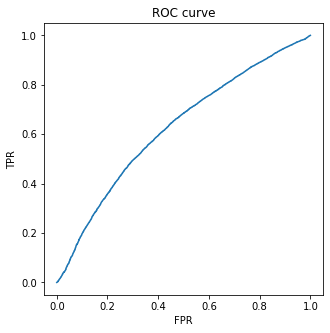

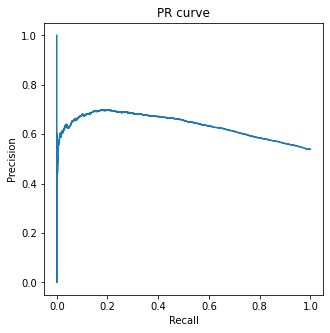

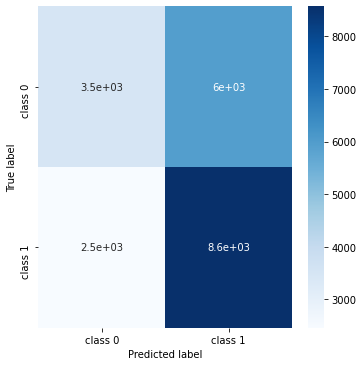

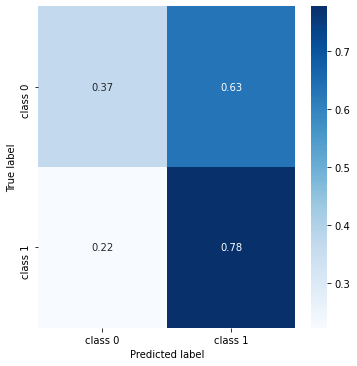

In [170]:
# fairing:include-cell
# Making sure directory is removed if already exists
if os.path.exists('/tmp/plots'):        
    shutil.rmtree('/tmp/plots')
os.mkdir('/tmp/plots')

target_names = ['class 0', 'class 1']

# Print Some Performance Metrics
print(classification_report(true_labels, pred_indices, target_names = target_names, zero_division = 0))
cr = classification_report(true_labels, pred_indices, target_names = target_names, zero_division=0, output_dict = True)
class_0_recall = np.around(cr['class 0']['recall'], decimals=5)
class_1_recall = np.around(cr['class 1']['recall'], decimals=5)
modeldb_expt_run.log_metrics({'Recall_Class_0': class_0_recall, 'Recall_Class_1': class_1_recall, })


# Create ROC curve
figure = plt.figure(figsize=(5, 5))
fpr, tpr, thresholds = roc_curve(true_labels, pred_indices_raw)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('/tmp/plots/roc.png')
modeldb_expt_run.log_artifact('ROC', '/tmp/plots/roc.png')

# Create PR curve
figure = plt.figure(figsize=(5, 5))
precision, recall, thresholds = precision_recall_curve(true_labels, pred_indices_raw)
plt.plot(recall, precision)
plt.title('PR curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('/tmp/plots/pr.png')
modeldb_expt_run.log_artifact('PR', '/tmp/plots/pr.png')


# Create confusion matrix
cm = confusion_matrix(true_labels, pred_indices)
cm_df = pd.DataFrame(cm, index = target_names, columns = target_names)
cm_normalize_df = pd.DataFrame(normalize(cm, 'l1', axis = 1), index = target_names, columns = target_names)
figure = plt.figure(figsize=(5, 5))
svm = sns.heatmap(cm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure = svm.get_figure()    
figure.savefig('/tmp/plots/cm.png')

figure = plt.figure(figsize=(5, 5))
svm = sns.heatmap(cm_normalize_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure = svm.get_figure()    
figure.savefig('/tmp/plots/cm_norm.png')

# Saving confusion_matrix
modeldb_expt_run.log_artifact('confusion_matrix', '/tmp/plots/cm.png')
modeldb_expt_run.log_artifact('confusion_matrix_normalized', '/tmp/plots/cm_norm.png')

In [ ]:
# fairing:include-cell
# Get LTR Metrics on a test-data set
if os.path.exists('/tmp/data'):        
    shutil.rmtree('/tmp/data')
os.mkdir('/tmp/data')

# Get predictions from the model
st = time.time()
model_predictions = sort_model.predict(test_data, verbose=1)
print('Process took {}secs'.format(time.time() - st))

# Construct a pandas dataframe with scores and target
st = time.time()
model_results_df = pd.DataFrame()
for f, t in test_data:
    temp = pd.DataFrame()
    temp[target_name] = t.numpy().ravel()
    temp['customer_id'] = f['customer_id']
    model_results_df = model_results_df.append(temp)
print('Process took {}secs'.format(time.time() - st))
model_results_df['predicted'] = model_predictions
prediction_column = 'predicted'

# Call the function to evaluate LTR metrics
model_metrics = pd.DataFrame()
model_hit_rate, model_ndcg = evaluation_utilities.get_ltr_metrics(model_results_df, 
                                                                         max_rank, 
                                                                         target_name, 
                                                                         prediction_column)

model_metrics['hit_rate'] = model_hit_rate
model_metrics['ndcg'] = model_ndcg

modeldb_expt_run.log_metrics({'HR_10': model_hit_rate[9], 'NDCG_10': model_ndcg[9]})
model_metrics.to_csv(f'/tmp/data/{modeldb_expt_run.name}.csv')
modeldb_expt_run.log_artifact('LTRMetrics', f'/tmp/data/{modeldb_expt_run.name}.csv')

10/10 [==============================] - 10s 935ms/step
Process took 10.353562355041504secs


In [ ]:
# fairing:include-cell
modeldb_expt_run.log_metric('experiment_run_duration_in_secs', (time.time() - start_time))            

### Run below cells to get information about the model

In [ ]:
#a_sort_model = get_sort_model(feature_normalizer)

In [ ]:
#a_sort_model.summary()

In [ ]:
#sort_model.get_layer(index=-1).summary()

In [ ]:
#sort_model.summary()

In [ ]:
#sort_model.get_layer(index=-1).summary()

### Run Below to evaluate model from checkpoint

In [ ]:
errout

In [ ]:
a_sort_model = get_sort_model(numeric_preprocessor=feature_normalizer)

In [ ]:
model_save_path = 'gs://personalization-tensorflow/models/text_features/4layer_1024_target_0_458_correct_age_gender_jqgdjbdo'
checkpoint_path = os.path.join(model_save_path, 'checkpoints/')

In [ ]:
a_sort_model.load_weights(checkpoint_path)

In [ ]:
# Get predictions from the model
st = time.time()
model_predictions = a_sort_model.predict(test_data, verbose = 1)
print('Process took {}secs'.format(time.time() - st))

# Construct a pandas dataframe with scores and target
st = time.time()
model_results_df = pd.DataFrame()
for f, t in test_data:
    temp = pd.DataFrame()
    temp[target_name] = t
    temp['customer_id'] = f['customer_id']
    model_results_df = model_results_df.append(temp)
print('Process took {}secs'.format(time.time() - st))
model_results_df['predicted'] = model_predictions
prediction_column = 'predicted'

# Call the function to evaluate LTR metrics
model_metrics = pd.DataFrame()
model_hit_rate, model_ndcg = evaluation_utilities.get_ltr_metrics(model_results_df, 
                                                                         max_rank, 
                                                                         target_name, 
                                                                         prediction_column)

model_metrics['hit_rate'] = model_hit_rate
model_metrics['ndcg'] = model_ndcg

In [ ]:
## Compare with BS Results
file_path_to_bs_results = "bs_results_on_test_test_v2.csv"
bs_model_metrics = pd.read_csv(file_path_to_bs_results)

In [ ]:
plt.figure()
plt.plot(np.arange(1,max_rank), model_metrics['hit_rate'], '*-', label='Text based model')
plt.plot(np.arange(1,max_rank), bs_model_metrics['hit_rate'], '*-', label='Estimated-demand based model')
plt.ylabel('HR@K')
plt.xlabel('K')
plt.grid(b=True)
plt.legend()

plt.figure()
plt.plot(np.arange(1,max_rank), model_metrics['ndcg'], '*-', label='Text based model')
plt.plot(np.arange(1,max_rank), bs_model_metrics['ndcg'], '*-', label='Estimated-demand based model')
plt.ylabel('NDCG@K')
plt.xlabel('K')
plt.grid(b=True)
plt.legend()

plt.show()